# Sensitivity analysis on effect differences from FFT window size

This file generates and displays data for the within-study parameter sensitivity analysis.

In [1]:
# imports
import os
from functools import partial
from math import log
from pathlib import Path

from IPython.display import clear_output
import pandas as pd

import tools.plots as plts
from tools.index_sensitivity import IndexSensitivity
from tools.r_link import Rlink
from study_settings.big_vicky import BigVickySettings, BigVickyToolbox
from study_settings.carara import CararaSettings, CararaToolbox

/usr/lib/python3/dist-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
/usr/lib/python3/dist-packages/paramiko/transport.py:261: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# settings and r_link
r_link = Rlink()
r_link.capture_rpy2_output(errorwarn_callback=print)
r_link.load_src("tools/r_funcs.R")
indices_of_interest = ["ACI", "ADI", "AEI", "BIO"]
output_path = Path("./output")
fft_window_sizes = [2**x for x in range(8, 16)] + [22050, 48000]
plts.plt.rcParams.update({"font.size": 16})

In [3]:
def experiment(df:pd.DataFrame, group_to_process:tuple, toolbox:IndexSensitivity, r_link:Rlink, marine:bool, factors:list, cross_effect:str):
    '''
    Models and obtains conditional effects for every set of values in the dataframe. Sets are defined by grouping the "Index", "Filtered", and "Band" columns.
    This function is designed for use in this notebook and may not generalise well.

    df: dataframe of index values
    group_to_process: tuple with the multi-index of the group to model
    toolbox: an instance of the IndexSensitivity class, with settings relevant to the data and models
    r_link: an instance of the Rlink class
    marine: whether the data is from Big Vicky's (True) or Carara (False)
    factors: which columns to treat as factors
    cross_effect: which column is treated as the cross effect (along with Window) 

    returns: a matplotlib figure of the model, and a table with the posterior effects summary
    '''
    samp_to_s = partial(toolbox.samples_to_s, toolbox.settings.sample_rate)
    s_to_samp = partial(toolbox.s_to_samples, toolbox.settings.sample_rate)
    conditional_effects = {}
    grouped_data = df.groupby(['Index', 'Filtered', 'Band'], observed=False) 
    group = grouped_data.get_group(group_to_process).copy()
    index, filtered, band = group_to_process
    log_window = index != "AEI"
    if log_window:
        group["Window"] = group["Window"].apply(lambda x: log(x))

    if index not in conditional_effects:
        conditional_effects[index] = {True: {}, False: {}}

    txt = '_filtered' if filtered else ''
    trunc = group["Truncation"].unique().max()
    trunc = 0 if not trunc else trunc # rpy2 conversion issue
    flt = txt.replace('_', ' ')
    all_text = (index, flt, band, cross_effect)
    model, effects = toolbox.build_model(r_link, marine, all_text, group, factors, trunc)
    clear_output()
    print(model)
    filename = output_path / f"{cross_effect}_x_Window_conditional_effects_for_{index}_over{txt}_{band}_frequencies_Python"
    secax = ("Window duration (s)", (samp_to_s, s_to_samp))
    fig = plts.plot_conditional_effects(r_link,
                                    filename, 
                                    effects, 
                                    plot_points=True, 
                                    sec_ax=secax, 
                                    colors=toolbox.settings.colors, 
                                    unlog=log_window)
    conditional_effects[index][filtered][band] = effects
    posterior_ratios = r_link.r_src.get_posterior_ratios(model, num=toolbox.settings.num, den=toolbox.settings.den, cross=cross_effect)
    posterior_effects = r_link.r_src.get_posterior_ratio_difference(posterior_ratios)

    warnings = r_link.r_src.get_warnings()
    if warnings != r_link.null_value:
        print(warnings)

    return fig, posterior_effects

In [4]:
# from tools.populate_ipynb import CellAdder
# print(CellAdder.generate_index_definitions())

In [5]:
# index definitions
broadband_ACI_group = ('ACI', False, 'broadband')
broadband_ADI_group = ('ADI', False, 'broadband')
broadband_AEI_group = ('AEI', False, 'broadband')
broadband_BIO_group = ('BIO', False, 'broadband')
fish_extracted_ACI_group = ('ACI', False, 'fish')
fish_extracted_ADI_group = ('ADI', False, 'fish')
fish_extracted_AEI_group = ('AEI', False, 'fish')
fish_extracted_BIO_group = ('BIO', False, 'fish')
fish_filtered_ACI_group = ('ACI', True, 'fish')
fish_filtered_ADI_group = ('ADI', True, 'fish')
fish_filtered_AEI_group = ('AEI', True, 'fish')
fish_filtered_BIO_group = ('BIO', True, 'fish')
shrimp_extracted_ACI_group = ('ACI', False, 'shrimp')
shrimp_extracted_ADI_group = ('ADI', False, 'shrimp')
shrimp_extracted_AEI_group = ('AEI', False, 'shrimp')
shrimp_extracted_BIO_group = ('BIO', False, 'shrimp')
shrimp_filtered_ACI_group = ('ACI', True, 'shrimp')
shrimp_filtered_ADI_group = ('ADI', True, 'shrimp')
shrimp_filtered_AEI_group = ('AEI', True, 'shrimp')
shrimp_filtered_BIO_group = ('BIO', True, 'shrimp')

## Carara

In [6]:
# settings and frequency bands
carara_settings = CararaSettings
carara_settings.data_location = os.path.expanduser(carara_settings.data_location)
test_bands = [("broadband", (0, carara_settings.max_freq), False)]


In [7]:
carara_toolbox = CararaToolbox(carara_settings, fft_window_sizes, test_bands, indices_of_interest)

In [8]:
carara_index_values = carara_toolbox.get_index_values(output_file="output/terrestrial_index_values")

In [9]:
carara_df = carara_toolbox.create_dataframe(carara_index_values, output_path="output/terrestrial_dataframe.pkl")

### Carara - broadband ACI


In [10]:
carara_broadband_ACI_fig, carara_broadband_ACI_ratio_summary = experiment(carara_df,
          broadband_ACI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2860) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.45      0.21     0.20     1.02 1.00     4689     6387

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.92      0.21    -1.37    -0.49 1.00     5161     6206
SiteIR            0.15      0.01     0.12     0.18 1.00    10710    13112
Window            1.02      0.00     1.02     1.03 1.00    15421    16064
SiteIR:Window    -0.02      0.00    -0.02    -0.02 1.00    10693    13041

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   175.70      4.63   166.67   184.85 

In [11]:
print(carara_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.12 0.00991



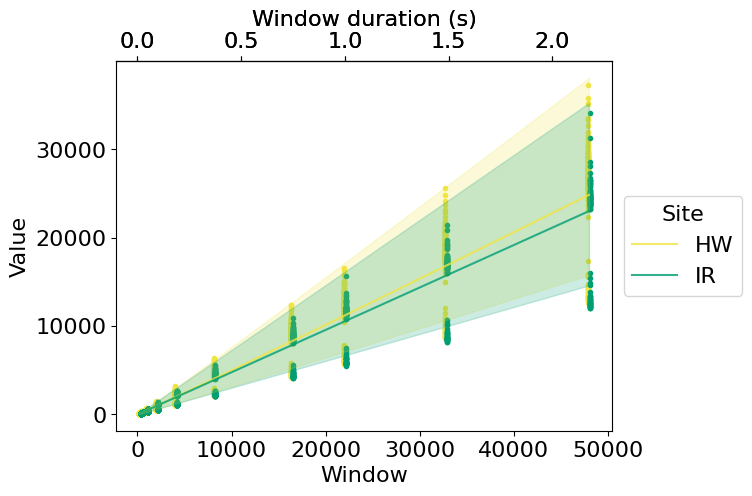

In [12]:
carara_broadband_ACI_fig


### Carara - broadband ADI


In [13]:
carara_broadband_ADI_fig, carara_broadband_ADI_ratio_summary = experiment(carara_df,
          broadband_ADI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value | trunc(ub = 4.69134788222914) ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2860) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.10      0.06     0.04     0.25 1.00     4021     2847

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.29      0.06     1.17     1.41 1.00     6911     7614
SiteIR           -0.00      0.06    -0.13     0.12 1.00    12033    13443
Window           -0.03      0.00    -0.04    -0.02 1.00    14633    16945
SiteIR:Window     0.01      0.01    -0.00     0.03 1.00    12064    13093

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape    11.

In [14]:
print(carara_broadband_ADI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.07 0.0313



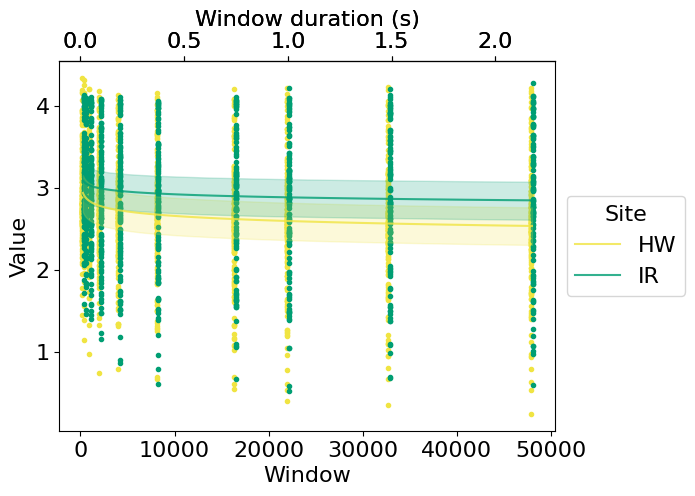

In [15]:
carara_broadband_ADI_fig


### Carara - broadband AEI


In [16]:
carara_broadband_AEI_fig, carara_broadband_AEI_ratio_summary = experiment(carara_df,
          broadband_AEI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2860) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.80      0.41     0.28     1.68 2.01        7       32

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.62      0.12     1.42     1.89 1.30       13       40
SiteIR           -0.26      0.04    -0.33    -0.18 1.01      580     1135
Window            0.00      0.00     0.00     0.00 1.00     5460    12268
SiteIR:Window    -0.00      0.00    -0.00     0.00 1.00     2281     6379

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    13.55      0.35    12.87    14.25 1.00 

In [17]:
print(carara_broadband_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.01 0.0105



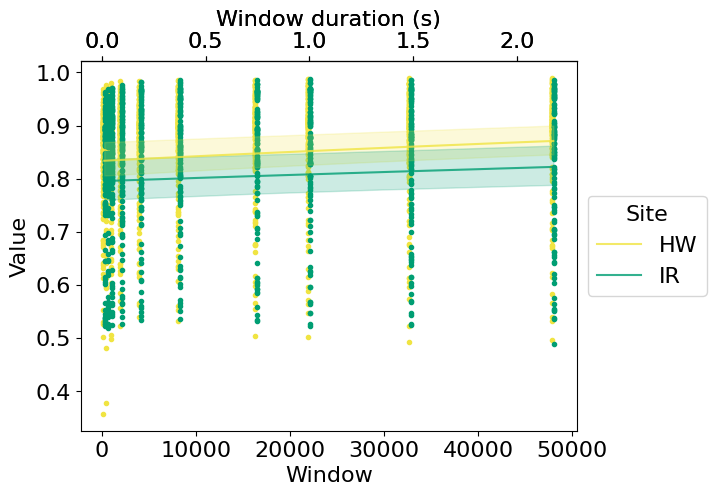

In [18]:
carara_broadband_AEI_fig


### Carara - broadband BIO


In [19]:
carara_broadband_BIO_fig, carara_broadband_BIO_ratio_summary = experiment(carara_df,
          broadband_BIO_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2860) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.96      0.46     0.44     2.17 1.00     5316     8631

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.24      0.45    -9.21    -7.30 1.00     5367     6958
SiteIR           -0.31      0.07    -0.44    -0.18 1.00    10387    12549
Window            2.04      0.00     2.03     2.05 1.00    12805    15060
SiteIR:Window     0.01      0.01    -0.01     0.02 1.00    10217    12265

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     8.41      0.22     7.99     8.85 

In [20]:
print(carara_broadband_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.04 0.0313



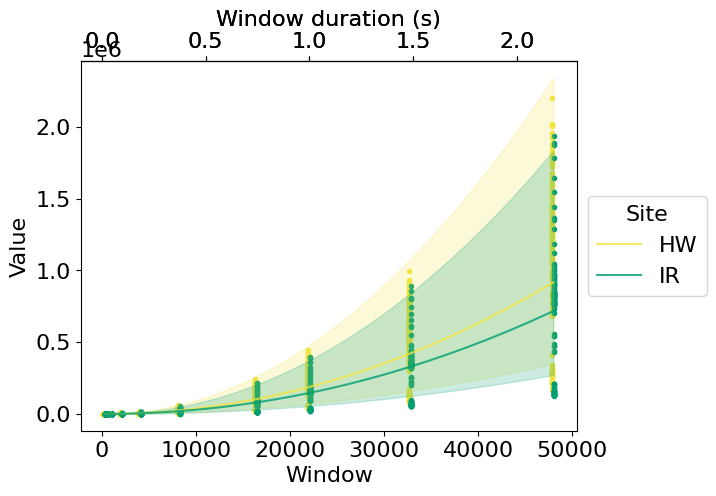

In [21]:
carara_broadband_BIO_fig


## Big Vicky

In [22]:
# settings and frequency bands
vicky_settings = BigVickySettings
vicky_settings.data_location = os.path.expanduser(vicky_settings.data_location)
test_bands = [("broadband", (100, vicky_settings.sample_rate), False),
              ("shrimp", vicky_settings.shrimp_frequencies, False),
              ("shrimp", vicky_settings.shrimp_frequencies, True),
              ("fish", vicky_settings.fish_frequencies, False),
              ("fish", vicky_settings.fish_frequencies, True)]


In [23]:
vicky_toolbox = BigVickyToolbox(vicky_settings, fft_window_sizes, test_bands, indices_of_interest)

In [24]:
vicky_index_values = vicky_toolbox.get_index_values(output_file="output/vicky_index_values.pkl")

In [25]:
vicky_df = vicky_toolbox.create_dataframe(vicky_index_values, output_path="output/vicky_dataframe.pkl")

### Big Vicky - broadband ACI


In [26]:
vicky_extracted_broadband_ACI_fig, vicky_extracted_broadband_ACI_ratio_summary = experiment(vicky_df,
          broadband_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.06      0.01     0.05     0.08 1.00     1600     2998

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.35      0.01     0.32     0.37 1.00     1621     2532
Hour12           -0.09      0.01    -0.11    -0.08 1.00     6602     8632
Window            0.92      0.00     0.92     0.92 1.00     9729    13475
Hour12:Window     0.02      0.00     0.02     0.02 1.00     6706     9087

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   416.84      7.98   401.46   432.

In [27]:
print(vicky_extracted_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.10 0.00440



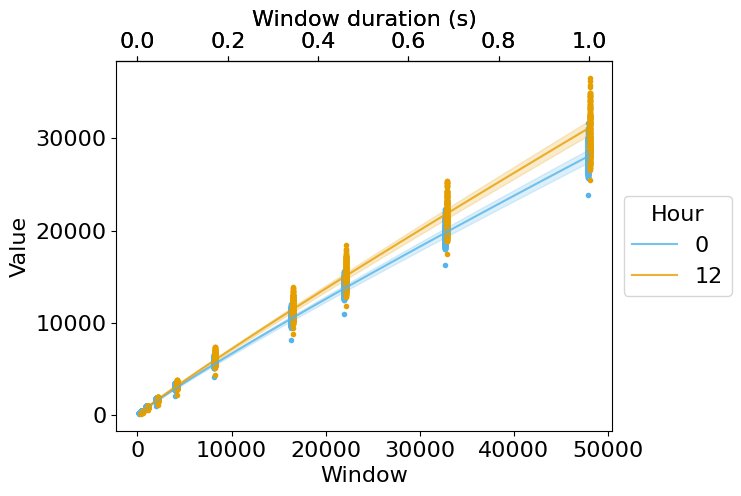

In [28]:
vicky_extracted_broadband_ACI_fig


### Big Vicky - extracted fish ACI


In [29]:
vicky_extracted_fish_ACI_fig, vicky_extracted_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.05      0.01     0.04     0.06 1.00     2157     4318

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -3.63      0.01    -3.66    -3.61 1.00     2606     4362
Hour12           -0.17      0.01    -0.19    -0.14 1.00     7570    11170
Window            0.97      0.00     0.97     0.97 1.00    10765    15760
Hour12:Window     0.02      0.00     0.01     0.02 1.00     7584    11147

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   147.42      2.79   141.97   152.

In [30]:
print(vicky_extracted_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.09 0.00745



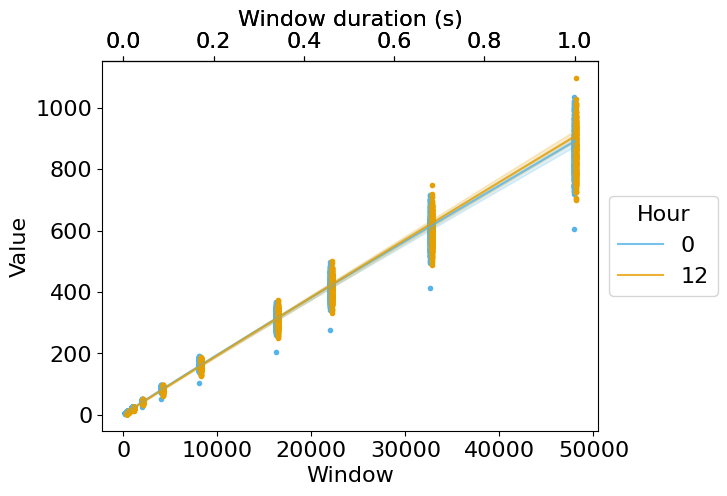

In [31]:
vicky_extracted_fish_ACI_fig


### Big Vicky - extracted shrimp ACI


In [32]:
vicky_extracted_shrimp_ACI_fig, vicky_extracted_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.05      0.01     0.03     0.06 1.00     2183     3697

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -1.67      0.01    -1.69    -1.64 1.00     1854     4029
Hour12           -0.14      0.01    -0.16    -0.13 1.00     7189    10129
Window            0.92      0.00     0.91     0.92 1.00    11234    16279
Hour12:Window     0.03      0.00     0.02     0.03 1.00     7357    10433

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   285.03      5.36   274.62   295.

In [33]:
print(vicky_extracted_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.15 0.00551



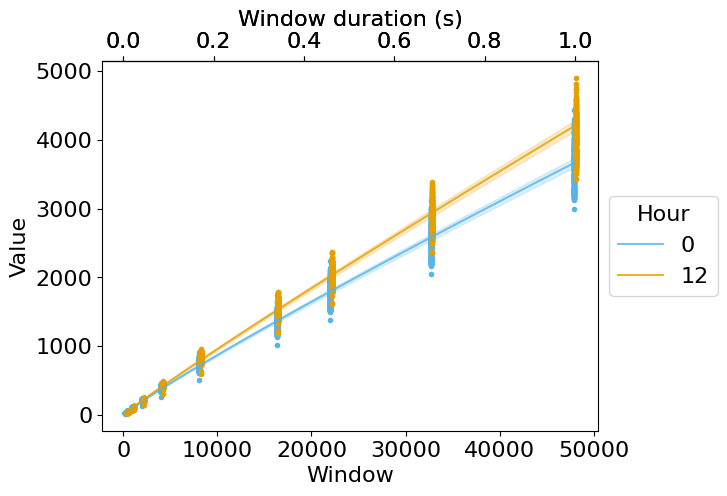

In [34]:
vicky_extracted_shrimp_ACI_fig


### Big Vicky - filtered fish ACI


In [35]:
vicky_filtered_fish_ACI_fig, vicky_filtered_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.01     0.01 1.00     2294     4611

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.50      0.00    -0.51    -0.50 1.00     4106     9607
Hour12           -0.01      0.00    -0.01    -0.00 1.00    19402    17932
Window            0.99      0.00     0.99     0.99 1.00    21917    19398
Hour12:Window     0.00      0.00     0.00     0.00 1.00    19520    17962

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  2275.99     43.74  2191.61  2362.

In [36]:
print(vicky_filtered_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00173



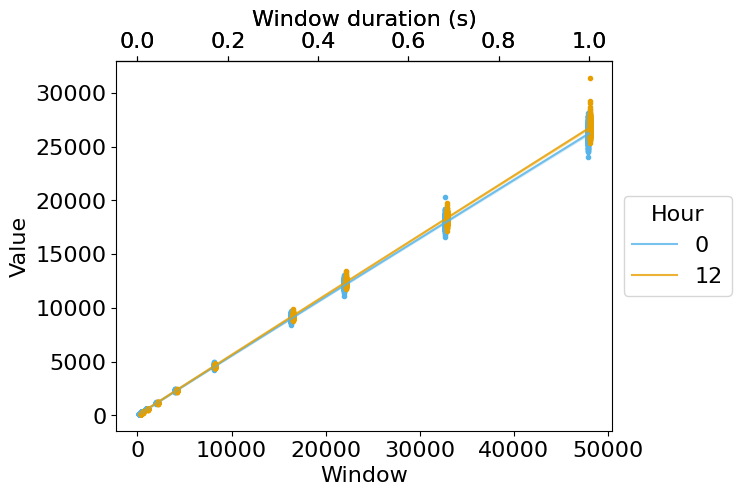

In [37]:
vicky_filtered_fish_ACI_fig


### Big Vicky - filtered shrimp ACI


In [38]:
vicky_filtered_shrimp_ACI_fig, vicky_filtered_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.01     0.03 1.00     1917     3207

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.26      0.00    -0.27    -0.25 1.00     1795     3224
Hour12           -0.04      0.00    -0.05    -0.04 1.00     9463    12099
Window            0.97      0.00     0.97     0.97 1.00    13279    15191
Hour12:Window     0.01      0.00     0.01     0.01 1.00     9604    12629

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1488.80     28.54  1433.24  1545.

In [39]:
print(vicky_filtered_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.05 0.00224



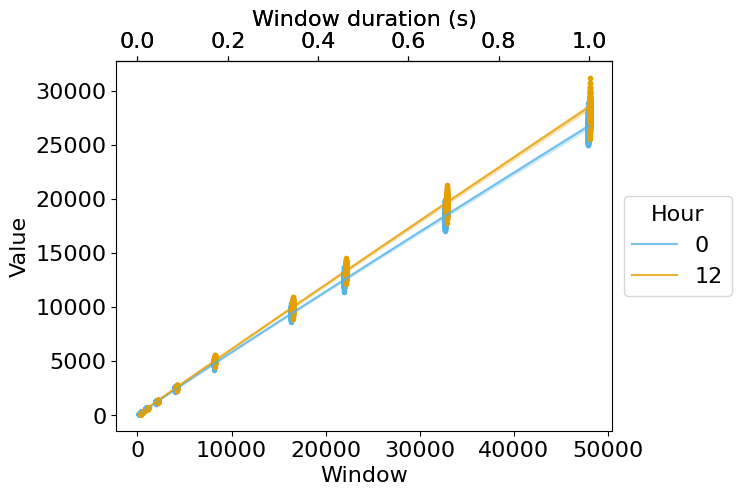

In [40]:
vicky_filtered_shrimp_ACI_fig


### Big Vicky - broadband ADI


In [41]:
vicky_extracted_broadband_ADI_fig, vicky_extracted_broadband_ADI_ratio_summary = experiment(vicky_df,
          broadband_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using ADI


ValueError: Not an rpy2 R object and unable to map it to one: 5.472270673671475

In [ ]:
print(vicky_extracted_broadband_ADI_ratio_summary)


In [ ]:
vicky_extracted_broadband_ADI_fig


### Big Vicky - extracted fish ADI


In [ ]:
vicky_extracted_fish_ADI_fig, vicky_extracted_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_extracted_fish_ADI_ratio_summary)


In [ ]:
vicky_extracted_fish_ADI_fig


### Big Vicky - extracted shrimp ADI


In [ ]:
vicky_extracted_shrimp_ADI_fig, vicky_extracted_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_extracted_shrimp_ADI_ratio_summary)


In [ ]:
vicky_extracted_shrimp_ADI_fig


### Big Vicky - filtered fish ADI


In [ ]:
vicky_filtered_fish_ADI_fig, vicky_filtered_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_filtered_fish_ADI_ratio_summary)


In [ ]:
vicky_filtered_fish_ADI_fig


### Big Vicky - filtered shrimp ADI


In [ ]:
vicky_filtered_shrimp_ADI_fig, vicky_filtered_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_filtered_shrimp_ADI_ratio_summary)


In [ ]:
vicky_filtered_shrimp_ADI_fig


### Big Vicky - broadband AEI


In [ ]:
vicky_extracted_broadband_AEI_fig, vicky_extracted_broadband_AEI_ratio_summary = experiment(vicky_df,
          broadband_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_extracted_broadband_AEI_ratio_summary)


In [ ]:
vicky_extracted_broadband_AEI_fig


### Big Vicky - extracted fish AEI


In [ ]:
vicky_extracted_fish_AEI_fig, vicky_extracted_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_extracted_fish_AEI_ratio_summary)


In [ ]:
vicky_extracted_fish_AEI_fig


### Big Vicky - extracted shrimp AEI


In [ ]:
vicky_extracted_shrimp_AEI_fig, vicky_extracted_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_extracted_shrimp_AEI_ratio_summary)


In [ ]:
vicky_extracted_shrimp_AEI_fig


### Big Vicky - filtered fish AEI


In [ ]:
vicky_filtered_fish_AEI_fig, vicky_filtered_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_filtered_fish_AEI_ratio_summary)


In [ ]:
vicky_filtered_fish_AEI_fig


### Big Vicky - filtered shrimp AEI


In [ ]:
vicky_filtered_shrimp_AEI_fig, vicky_filtered_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_filtered_shrimp_AEI_ratio_summary)


In [ ]:
vicky_filtered_shrimp_AEI_fig


### Big Vicky - broadband BIO


In [ ]:
vicky_extracted_broadband_BIO_fig, vicky_extracted_broadband_BIO_ratio_summary = experiment(vicky_df,
          broadband_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_extracted_broadband_BIO_ratio_summary)


In [ ]:
vicky_extracted_broadband_BIO_fig


### Big Vicky - extracted fish BIO


In [ ]:
vicky_extracted_fish_BIO_fig, vicky_extracted_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_extracted_fish_BIO_ratio_summary)


In [ ]:
vicky_extracted_fish_BIO_fig


### Big Vicky - extracted shrimp BIO


In [ ]:
vicky_extracted_shrimp_BIO_fig, vicky_extracted_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_extracted_shrimp_BIO_ratio_summary)


In [ ]:
vicky_extracted_shrimp_BIO_fig


### Big Vicky - filtered fish BIO


In [ ]:
vicky_filtered_fish_BIO_fig, vicky_filtered_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_filtered_fish_BIO_ratio_summary)


In [ ]:
vicky_filtered_fish_BIO_fig


### Big Vicky - filtered shrimp BIO


In [ ]:
vicky_filtered_shrimp_BIO_fig, vicky_filtered_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


In [ ]:
print(vicky_filtered_shrimp_BIO_ratio_summary)


In [ ]:
vicky_filtered_shrimp_BIO_fig
